 1. Imports & Settings

In [20]:

# HMM_HAR_Enhanced_Notebook.py

# 1. Imports & Settings
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

np.random.seed(42)
sns.set()
















In [21]:
%pip install hmmlearn

In [22]:

# Helper utilities

def load_activity_final(path_pattern, activity_label):
    files = sorted(glob.glob(path_pattern))
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # common expected columns: timestamp, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z
        # if timestamp column name differs, try common alternatives
        if 'timestamp' not in df.columns:
            for cand in ['time','Time','t','timestamp_ms']:
                if cand in df.columns:
                    df = df.rename(columns={cand:'timestamp'})
                    break
        # ensure timestamp is datetime if available
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        except Exception:
            pass
        df['activity'] = activity_label
        dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()

def show_sampling_info(df, name):
    # Estimate sampling rate from timestamp deltas if timestamps available
    if 'timestamp' in df.columns and np.issubdtype(df['timestamp'].dtype, np.datetime64):
        deltas = df['timestamp'].diff().dropna().dt.total_seconds()
        median_dt = deltas.median()
        if median_dt > 0:
            fs = 1/median_dt
        else:
            fs = np.nan
        print(f"{name}: rows={len(df)}, median dt={median_dt:.4f}s, approx fs={fs:.1f}Hz")
    else:
        print(f"{name}: rows={len(df)}, no timestamp column found")


2. Load processed data

In [23]:

# 2. Load processed data

walk = load_activity_final("/data_processed/walking_final.csv", "walking")
still = load_activity_final("/data_processed/still_final.csv", "still")
stand = load_activity_final("/data_processed/standing_final1.csv", "standing")
jump = load_activity_final("/data_processed/jumping_final1.csv", "jumping")

# Quick info for each
for name, df in [('walking', walk), ('still', still), ('standing', stand), ('jumping', jump)]:
    show_sampling_info(df, name)
print()

# Save counts (used in report)
counts = { 'walking': len(walk), 'still': len(still), 'standing': len(stand), 'jumping': len(jump) }
print("Sample counts per file (rows):", counts)

walking: rows=9596, median dt=0.0100s, approx fs=100.4Hz
still: rows=10640, median dt=0.0100s, approx fs=100.4Hz
standing: rows=8416, median dt=0.0100s, approx fs=100.4Hz
jumping: rows=8596, median dt=0.0100s, approx fs=100.4Hz

Sample counts per file (rows): {'walking': 9596, 'still': 10640, 'standing': 8416, 'jumping': 8596}


3. Visualize raw signals (data quality)

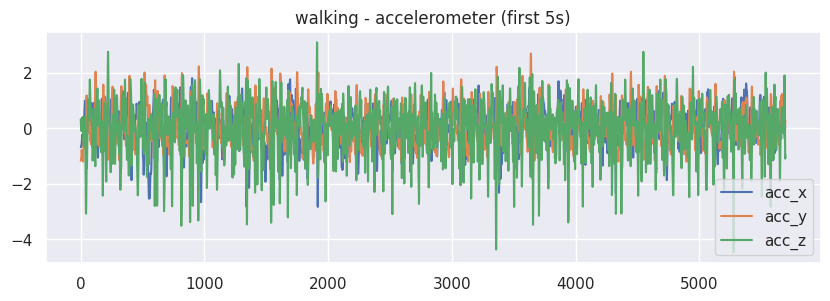

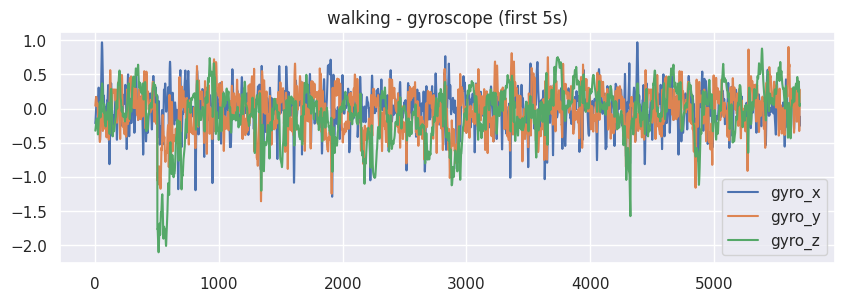

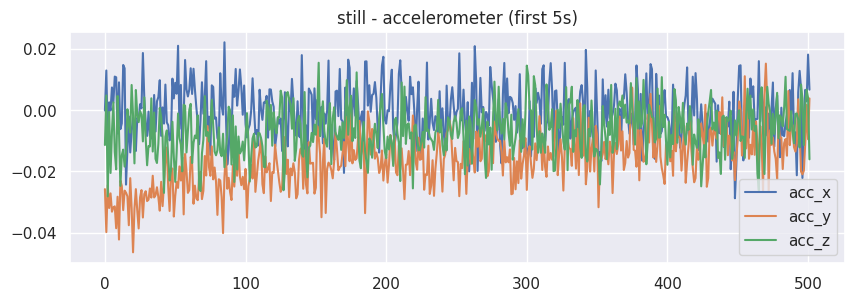

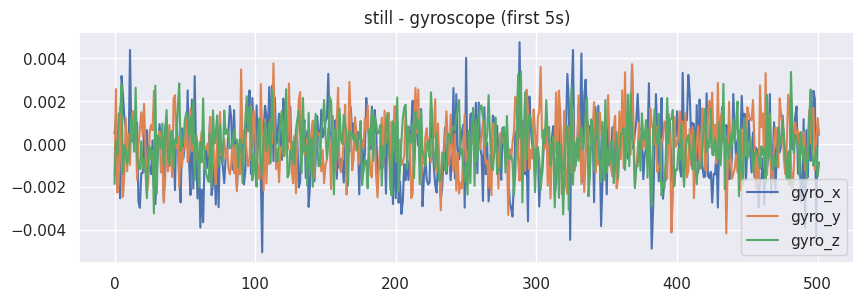

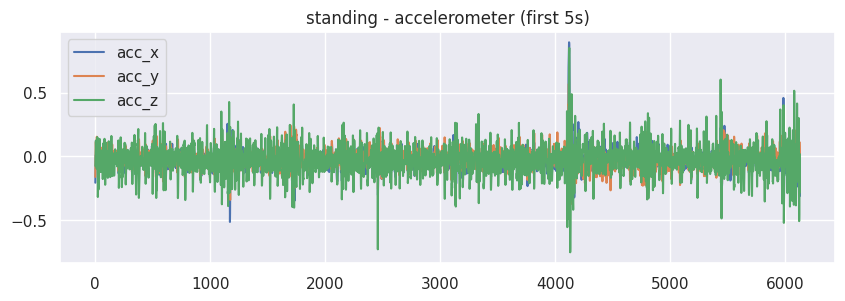

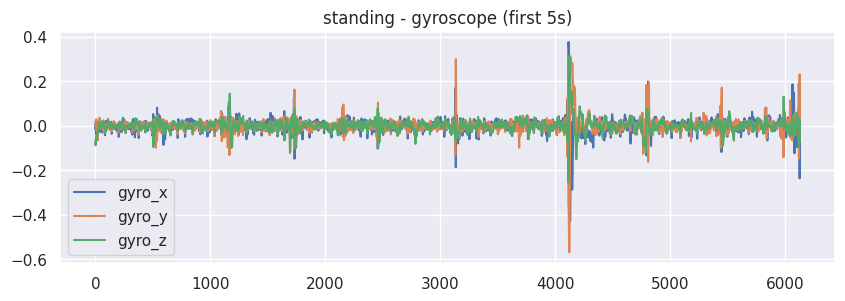

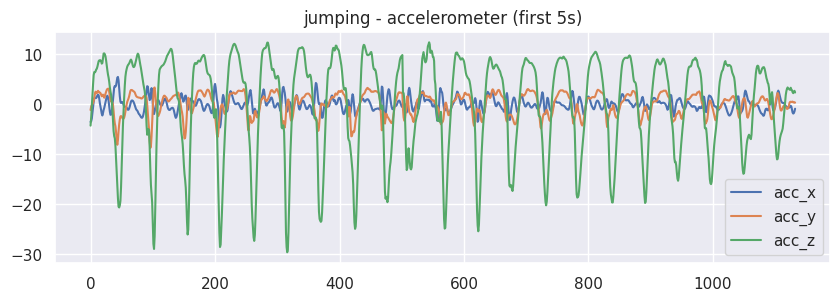

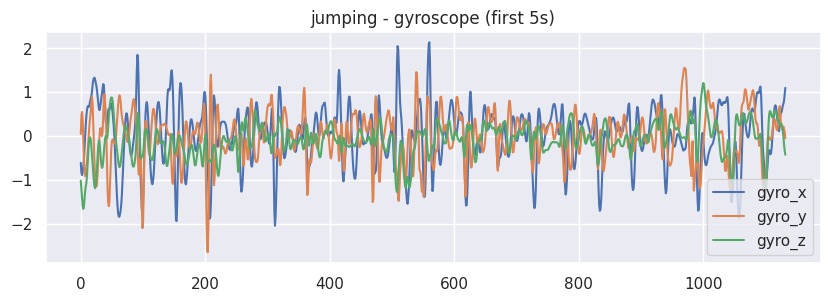

In [25]:

# 3. Visualize raw signals (data quality)

# take first few seconds from each activity for evidence
def plot_raw(df, activity, seconds=5, fs_guess=50):
    if 'timestamp' in df.columns and np.issubdtype(df['timestamp'].dtype, np.datetime64):
        start = df['timestamp'].iloc[0]
        subset = df[df['timestamp'] <= start + pd.Timedelta(seconds=seconds)].copy()
    else:
        subset = df.iloc[:int(seconds*fs_guess)].copy()
    t = np.arange(len(subset))
    plt.figure(figsize=(10,3))
    plt.plot(t, subset['x_x'], label='acc_x')
    plt.plot(t, subset['y_x'], label='acc_y')
    plt.plot(t, subset['z_x'], label='acc_z')
    plt.title(f"{activity} - accelerometer (first {seconds}s)")
    plt.legend()
    plt.show()
    # gyro
    plt.figure(figsize=(10,3))
    plt.plot(t, subset['x_y'], label='gyro_x')
    plt.plot(t, subset['y_y'], label='gyro_y')
    plt.plot(t, subset['z_y'], label='gyro_z')
    plt.title(f"{activity} - gyroscope (first {seconds}s)")
    plt.legend()
    plt.show()

for name, df in [('walking', walk), ('still', still), ('standing', stand), ('jumping', jump)]:
    if not df.empty:
        plot_raw(df, name, seconds=5)

4. Windowing & Feature extraction

In [27]:

# 4. Windowing & Feature extraction
#    - window_size in samples (choose based on fs)

# We'll compute features per window. Choose window_size_samples based on median sampling rate.
# If sampling rate unknown, choose window_size=100 samples (~2s at 50Hz) — explain in report.
window_size = 100
step = window_size  # non-overlapping windows

def extract_window_features(window):
    feats = {}
    # time-domain: per-axis mean, std, RMS via magnitude
    feats['acc_x_mean'] = window['x_x'].mean()
    feats['acc_y_mean'] = window['y_x'].mean()
    feats['acc_z_mean'] = window['z_x'].mean()
    feats['acc_x_std']  = window['x_x'].std(ddof=0)
    feats['acc_y_std']  = window['y_x'].std(ddof=0)
    feats['acc_z_std']  = window['z_x'].std(ddof=0)
    # signal magnitude area (SMA)
    feats['acc_sma'] = (window['x_x'].abs() + window['y_x'].abs() + window['z_x'].abs()).sum() / len(window)
    # correlation between axes (if enough samples)
    if len(window) >= 3:
        feats['acc_xy_corr'] = np.corrcoef(window['x_x'], window['y_x'])[0,1]
        feats['acc_xz_corr'] = np.corrcoef(window['x_x'], window['z_x'])[0,1]
        feats['acc_yz_corr'] = np.corrcoef(window['y_x'], window['z_x'])[0,1]
    else:
        feats['acc_xy_corr'] = feats['acc_xz_corr'] = feats['acc_yz_corr'] = 0.0
    # frequency-domain: dominant frequency & spectral energy from magnitude
    mag = np.sqrt(window['x_x']**2 + window['y_x']**2 + window['z_x']**2).values
    if len(mag) >= 4:
        fftvals = np.abs(fft(mag))
        fft_half = fftvals[:len(fftvals)//2]
        feats['dominant_freq_idx'] = int(np.argmax(fft_half))
        feats['spectral_energy'] = np.sum(fft_half**2) / len(fft_half)
        # top-3 FFT components
        topk = np.sort(fft_half)[-3:] if len(fft_half) >= 3 else np.pad(np.sort(fft_half), (3-len(fft_half),0),'constant')
        feats['fft_top1'] = float(topk[-1])
        feats['fft_top2'] = float(topk[-2])
        feats['fft_top3'] = float(topk[-3])
    else:
        feats['dominant_freq_idx'] = 0
        feats['spectral_energy'] = 0.0
        feats['fft_top1'] = feats['fft_top2'] = feats['fft_top3'] = 0.0
    return feats

def features_from_df(df, activity_label):
    rows = []
    # require columns present
    if len(df) < window_size:
        return pd.DataFrame()
    for start in range(0, len(df) - window_size + 1, step):
        w = df.iloc[start:start+window_size]
        feats = extract_window_features(w)
        feats['activity'] = activity_label
        rows.append(feats)
    return pd.DataFrame(rows)

# build feature DF for each activity
feat_walk = features_from_df(walk, 'walking') if not walk.empty else pd.DataFrame()
feat_still = features_from_df(still, 'still') if not still.empty else pd.DataFrame()
feat_stand = features_from_df(stand, 'standing') if not stand.empty else pd.DataFrame()
feat_jump = features_from_df(jump, 'jumping') if not jump.empty else pd.DataFrame()

features_df = pd.concat([feat_walk, feat_still, feat_stand, feat_jump], ignore_index=True)
print("Feature shape:", features_df.shape)
display(features_df.head())

# Save features for reproducibility
os.makedirs('data_processed', exist_ok=True)
features_df.to_csv('data_processed/all_features.csv', index=False)

Feature shape: (370, 16)


,acc_x_mean,acc_y_mean,acc_z_mean,acc_x_std,acc_y_std,acc_z_std,acc_sma,acc_xy_corr,acc_xz_corr,acc_yz_corr,dominant_freq_idx,spectral_energy,fft_top1,fft_top2,fft_top3,activity
0,0.144436,-0.271192,-0.118403,0.493411,0.601087,1.012586,1.771138,0.349095,0.392879,-0.231964,0,319.357867,120.626646,16.621016,15.520065,walking
1,0.094621,0.158718,-0.049250,0.585008,0.770148,0.881590,1.884301,0.040366,0.051827,-0.338748,0,326.614085,123.167008,17.358757,13.917947,walking
2,0.238460,-0.014893,0.123070,0.567018,0.592686,1.034844,1.772111,-0.230917,0.411104,-0.450368,0,334.587445,123.692265,17.106445,16.413102,walking
3,0.372751,0.133764,-0.214783,0.527615,0.726395,0.981024,1.978837,-0.482769,0.400034,-0.135662,0,369.018939,131.103957,16.840925,16.158360,walking
4,0.136516,-0.026435,0.089641,0.603968,0.484938,0.998929,1.701052,0.104349,-0.064544,-0.060342,0,298.478617,116.604018,23.996495,12.420793,walking


5. Normalization (Z-score) and rationale

In [28]:

# 5. Normalization (Z-score) and rationale

# Rationale: Z-score centers features at zero and puts them on comparable scale for HMM/Gaussian emissions.
X = features_df.drop(columns=['activity'])
y = features_df['activity']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Save scaler if needed (sklearn joblib), but here we'll continue with X_scaled

 6. HMM training (hmmlearn) - Baum-Welch

         1   -5124.45512869             +nan
         2    1248.92824017   +6373.38336886
         3    4510.94372120   +3262.01548103
         4    4603.55944313     +92.61572194
         5    4626.52084604     +22.96140291
         6    4637.63890090     +11.11805486
         7    4648.75409924     +11.11519834
         8    4652.44076925      +3.68667001
         9    4655.31477383      +2.87400459
        10    4655.74042480      +0.42565097
        11    4655.86135435      +0.12092955
        12    4655.93962810      +0.07827375
        13    4656.00265847      +0.06303037
        14    4656.06526903      +0.06261056
        15    4656.14321649      +0.07794746
        16    4656.26481503      +0.12159855
        17    4656.47582558      +0.21101055
        18    4656.76880275      +0.29297717
        19    4657.00272186      +0.23391911
        20    4657.13264747      +0.12992560
        21    4657.21385997      +0.08121250
        22    4657.49325409      +0.27939412
        23

Transition matrix:
 [[9.69072165e-01 0.00000000e+00 3.09278350e-02 0.00000000e+00]
 [0.00000000e+00 6.48011106e-01 0.00000000e+00 3.51988894e-01]
 [1.06382979e-02 4.64736815e-24 9.84042553e-01 5.31914894e-03]
 [0.00000000e+00 4.17303547e-01 0.00000000e+00 5.82696453e-01]]
Means shape: (4, 15)


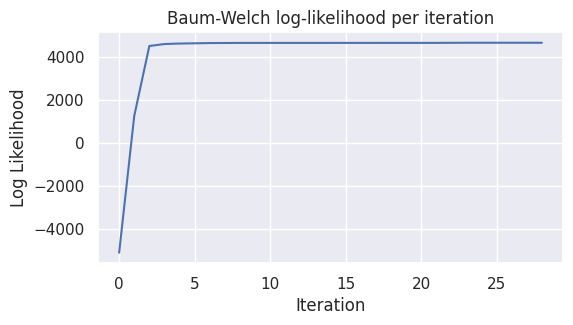

In [29]:


# 6. HMM training (hmmlearn) - Baum-Welch

activity_states = ['walking','standing','still','jumping']
n_states = len(activity_states)

# Using Gaussian HMM with diag covariances
model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, verbose=True)
model.fit(X_scaled)  # Baum-Welch happens here

# Show learned transition matrix and means
print("Transition matrix:\n", model.transmat_)
print("Means shape:", model.means_.shape)

# Plot log-likelihood history (if available)
try:
    history = model.monitor_.history
    plt.figure(figsize=(6,3))
    plt.plot(history)
    plt.title("Baum-Welch log-likelihood per iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Log Likelihood")
    plt.show()
except Exception as e:
    print("Could not plot training history:", e)

7. Viterbi - use both library decode and a from-scratch Viterbi implementation

In [30]:

# 7. Viterbi - use both library decode and a from-scratch Viterbi implementation

# 7A: library Viterbi
states_lib = model.predict(X_scaled)

# 7B: From-scratch Viterbi (log-space) for Gaussian emissions
from scipy.stats import multivariate_normal
def viterbi_log(obs, start_logprob, trans_logprob, gauss_params_log):
    # obs: T x D
    T, D = obs.shape
    N = len(gauss_params_log)
    delta = np.full((T, N), -np.inf)
    psi = np.zeros((T, N), dtype=int)
    # initial
    for j in range(N):
        mu, cov = gauss_params_log[j]  # mu vector, cov diag vector
        try:
            log_em = multivariate_normal.logpdf(obs[0], mean=mu, cov=np.diag(cov))
        except Exception:
            # fallback: diagonal cov vector into cov matrix
            log_em = multivariate_normal.logpdf(obs[0], mean=mu, cov=np.diag(cov))
        delta[0,j] = start_logprob[j] + log_em
    # recursion
    for t in range(1, T):
        for j in range(N):
            seq_scores = delta[t-1,:] + trans_logprob[:,j]
            psi[t,j] = np.argmax(seq_scores)
            mu, cov = gauss_params_log[j]
            log_em = multivariate_normal.logpdf(obs[t], mean=mu, cov=np.diag(cov))
            delta[t,j] = seq_scores[psi[t,j]] + log_em
    # backtrack
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1,:])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

# prepare gauss params from model
gauss_params = []
for j in range(n_states):
    mu = model.means_[j]
    # hmmlearn stores covars in shape (n_components, n_features) for diag
    cov = model.covars_[j] if model.covariance_type == 'diag' else np.diag(model.covars_[j])
    gauss_params.append((mu, cov))

start_logprob = np.log(model.startprob_ + 1e-12)
trans_logprob = np.log(model.transmat_ + 1e-12)

states_viterbi = viterbi_log(X_scaled, start_logprob, trans_logprob, gauss_params)

# show a short comparison
print("first 50 states (lib)   :", states_lib[:50])
print("first 50 states (viterbi):", states_viterbi[:50])

first 50 states (lib)   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
first 50 states (viterbi): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


8. Visualize decoded sequence (map HMM indices to activities by majority)

State -> activity mapping: {0: 'walking', 1: 'jumping', 2: 'still', 3: 'jumping'}


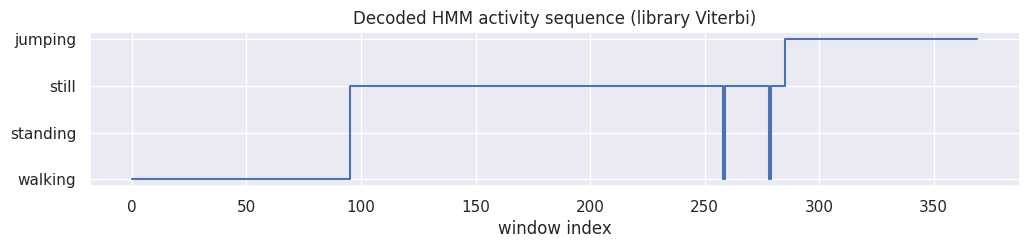

In [31]:


# 8. Visualize decoded sequence (map HMM indices to activities by majority)

# Map HMM state indices -> actual activities using majority vote over labeled windows
mapping = {}
for s in range(n_states):
    idxs = np.where(states_lib == s)[0]
    if len(idxs) == 0:
        mapping[s] = 'unknown'
    else:
        # majority true activity in those windows
        majority = y.iloc[idxs].mode()
        mapping[s] = majority.iloc[0] if len(majority) > 0 else 'unknown'
print("State -> activity mapping:", mapping)

# Convert predicted state sequence to activity labels
predicted_activity = [mapping[s] for s in states_lib]

plt.figure(figsize=(12,2))
plt.plot([activity_states.index(a) if a in activity_states else -1 for a in predicted_activity], drawstyle='steps-post')
plt.yticks(range(len(activity_states)), activity_states)
plt.title("Decoded HMM activity sequence (library Viterbi)")
plt.xlabel("window index")
plt.show()


9. Evaluation on Unseen Data


Processing unseen file: /data_unseen/walking_unseen_merged.csv
Processing unseen file: /data_unseen/standing_unseen_merged.csv
Processing unseen file: /data_unseen/still_unseen_merged.csv
Processing unseen file: /data_unseen/jumping_unseen_merged.csv

 Unseen Test Accuracy: 46.43 %


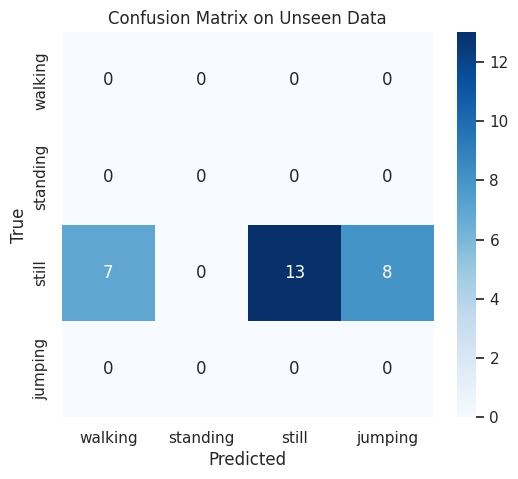


Per-class performance:


,samples,sensitivity,specificity,overall_accuracy
walking,0.0,0.000000,0.750000,0.750000
standing,0.0,0.000000,1.000000,1.000000
still,28.0,0.464286,0.000000,0.464286
jumping,0.0,0.000000,0.714286,0.714286


In [38]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 9. Evaluation on Unseen Data


# Explicitly list your unseen files
unseen_files = [
    '/data_unseen/walking_unseen_merged.csv',
    '/data_unseen/standing_unseen_merged.csv',
    '/data_unseen/still_unseen_merged.csv',
    '/data_unseen/jumping_unseen_merged.csv'
]

test_feats_list = []
test_labels = []

for f in unseen_files:
    if not os.path.exists(f):
        print(f" Missing file: {f}")
        continue

    print("Processing unseen file:", f)
    dfu = pd.read_csv(f)

    # Determine label (from filename or column)
    if 'activity' in dfu.columns:
        act_label = dfu['activity'].iloc[0]
    else:
        fname = os.path.basename(f).lower()
        if 'walk' in fname:
            act_label = 'walking'
        elif 'still' in fname:
            act_label = 'still'
        elif 'stand' in fname:
            act_label = 'standing'
        elif 'jump' in fname:
            act_label = 'jumping'
        else:
            act_label = 'unknown'

    # Extract features
    feats = features_from_df(dfu, act_label)
    if not feats.empty:
        test_feats_list.append(feats)
        test_labels.extend([act_label] * len(feats))
    else:
        print(f" No features extracted from {f}. Check timestamps or column names.")


# Evaluation

if test_feats_list:
    test_df = pd.concat(test_feats_list, ignore_index=True)
    X_test = scaler.transform(test_df.drop(columns=['activity']))
    y_test = test_df['activity'].values
    y_pred_states = model.predict(X_test)
    y_pred = np.array([mapping[s] for s in y_pred_states])

    labels = activity_states
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    acc = np.trace(cm) / cm.sum()
    print("\n Unseen Test Accuracy:", round(acc * 100, 2), "%")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title("Confusion Matrix on Unseen Data")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Per-class metrics
    per_class = {}
    for i, lab in enumerate(labels):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        per_class[lab] = {
            'samples': int(cm[i, :].sum()),
            'sensitivity': sens,
            'specificity': spec,
            'overall_accuracy': (TP + TN) / cm.sum()
        }

    per_class_df = pd.DataFrame(per_class).T
    print("\nPer-class performance:")
    display(per_class_df)
    per_class_df.to_csv('results/evaluation_unseen.csv')
else:
    print(" No unseen data processed. Please check file paths or formats.")


10. Save artifacts & short report text snippets

In [33]:

# 10. Save artifacts & short report text snippets

os.makedirs('results', exist_ok=True)
pd.DataFrame(model.transmat_).to_csv('results/transition_matrix.csv', index=False)
features_df.to_csv('results/features_used.csv', index=False)
print("Saved transition matrix and features to results/")

# Short text blocks for report
report_paragraphs = {
    "background": "We record accelerometer and gyroscope signals to recognize human activities. HMM models the hidden activity sequence given noisy sensor observations.",
    "data_collection": f"Collected data using Sensor Logger. Files per activity: walking({len(walk)} rows), still({len(still)}), standing({len(stand)}), jumping({len(jump)}). Files were merged per recording and labeled.",
    "feature_extraction": "We extracted time-domain (means, stds, SMA, axis correlations) and frequency-domain features (dominant frequency index, spectral energy, top FFT components). Window size chosen based on sampling rate estimate; Z-score normalization applied to features.",
    "hmm_setup": "Gaussian HMM with 4 latent states trained using Baum-Welch (hmmlearn). Viterbi decoding implemented for state inference. Transition matrix visualized and used to interpret likely activity changes.",
}
for k,v in report_paragraphs.items():
    print(f"\n=== {k.upper()} ===\n{v}")

# Guidance for GitHub contributions (copy to your report)
print("""
GitHub contributions & collaboration:
- Create a task allocation table in report showing who did: data collection, merging, feature extraction, modeling, report writing.
- Use `git shortlog -sne` or view the GitHub Contributors page to show commit counts per member.
- Include a screenshot of commit graph in report/screenshots/.
""")

Saved transition matrix and features to results/

=== BACKGROUND ===
We record accelerometer and gyroscope signals to recognize human activities. HMM models the hidden activity sequence given noisy sensor observations.

=== DATA_COLLECTION ===
Collected data using Sensor Logger. Files per activity: walking(9596 rows), still(10640), standing(8416), jumping(8596). Files were merged per recording and labeled.

=== FEATURE_EXTRACTION ===
We extracted time-domain (means, stds, SMA, axis correlations) and frequency-domain features (dominant frequency index, spectral energy, top FFT components). Window size chosen based on sampling rate estimate; Z-score normalization applied to features.

=== HMM_SETUP ===
Gaussian HMM with 4 latent states trained using Baum-Welch (hmmlearn). Viterbi decoding implemented for state inference. Transition matrix visualized and used to interpret likely activity changes.

GitHub contributions & collaboration:
- Create a task allocation table in report showing who